## makemore: becoming a backprop ninja

swole doge style


In [123]:
# there no change change in the first several cells from last lecture

In [124]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [125]:
# read in all the words
words = open("names.txt", "r").read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [126]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [127]:
# build the dataset
block_size = (
    3  # context length: how many characters do we take to predict the next one?
)


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])  # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [128]:
# ok biolerplate done, now we get to the action:

In [129]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(
        f"{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}"
    )

In [130]:
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 64  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
# Layer 1
W1 = (
    torch.randn((n_embd * block_size, n_hidden), generator=g)
    * (5 / 3)
    / ((n_embd * block_size) ** 0.5)
)
b1 = (
    torch.randn(n_hidden, generator=g) * 0.1
)  # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

4137


In [131]:
batch_size = 32
n = batch_size  # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

In [132]:
print(C.shape, Xb.shape, C[Xb].shape)
Xb[0:2, :], C[Xb][0:2, :], b1.shape

torch.Size([27, 10]) torch.Size([32, 3]) torch.Size([32, 3, 10])


(tensor([[ 1,  1,  4],
         [18, 14,  1]]),
 tensor([[[-4.7125e-01,  7.8682e-01, -3.2843e-01, -4.3297e-01,  1.3729e+00,
            2.9334e+00,  1.5618e+00, -1.6261e+00,  6.7716e-01, -8.4039e-01],
          [-4.7125e-01,  7.8682e-01, -3.2843e-01, -4.3297e-01,  1.3729e+00,
            2.9334e+00,  1.5618e+00, -1.6261e+00,  6.7716e-01, -8.4039e-01],
          [-9.6478e-01, -2.3211e-01, -3.4762e-01,  3.3244e-01, -1.3263e+00,
            1.1224e+00,  5.9641e-01,  4.5846e-01,  5.4011e-02, -1.7400e+00]],
 
         [[ 1.2815e+00, -6.3182e-01, -1.2464e+00,  6.8305e-01, -3.9455e-01,
            1.4388e-02,  5.7216e-01,  8.6726e-01,  6.3149e-01, -1.2230e+00],
          [ 4.6827e-01, -6.5650e-01,  6.1662e-01, -6.2197e-01,  5.1007e-01,
            1.3563e+00,  2.3445e-01, -4.5585e-01, -1.3132e-03, -5.1161e-01],
          [-4.7125e-01,  7.8682e-01, -3.2843e-01, -4.3297e-01,  1.3729e+00,
            2.9334e+00,  1.5618e+00, -1.6261e+00,  6.7716e-01, -8.4039e-01]]],
        grad_fn=<SliceBackwar

In [133]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb]  # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1  # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1 / n * hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = (
    1 / (n - 1) * (bndiff2).sum(0, keepdim=True)
)  # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5) ** -0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact)  # hidden layer
# Linear layer 2
logits = h @ W2 + b2  # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes  # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = (
    counts_sum**-1
)  # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [
    logprobs,
    probs,
    counts,
    counts_sum,
    counts_sum_inv,  # afaik there is no cleaner way
    norm_logits,
    logit_maxes,
    logits,
    h,
    hpreact,
    bnraw,
    bnvar_inv,
    bnvar,
    bndiff2,
    bndiff,
    hprebn,
    bnmeani,
    embcat,
    emb,
]:
    t.retain_grad()
loss.backward()
loss

tensor(3.3539, grad_fn=<NegBackward0>)

In [266]:
bngain.shape, dL_dhpreact.shape

(torch.Size([1, 64]), torch.Size([32, 64]))

In [265]:
# Exercise 1: backprop through the whole thing manually,
# backpropagating through exactly all of the variables
# as they are defined in the forward pass above, one by one
dL_dlp = torch.zeros_like(logprobs)
dL_dlp[range(n), Yb] = -1.0 / n
assert dL_dlp.shape == logprobs.shape
dlp_dp = 1.0 / probs
dL_dp = dlp_dp * dL_dlp
assert dL_dp.shape == probs.shape
dp_dcsuminv = counts
dL_csuminv = (dL_dp * dp_dcsuminv).sum(1, keepdim=True)
assert dL_csuminv.shape == counts_sum_inv.shape
"""cumulative sums add everything along row (spans column directions, left to right)
	Have something like where probs = counts_SUM_invertedOrNot[32x1] @ dLdp[32x27] (csi broadcasts to [32x27]):
	csi1*L11 csi1*L12 csi1*L13... ==> dprobs/dcsi[j] gives back counts entry corresponding to each j
	csi2*L21 csi2*L22 csi2*L23... SUM csi2*L21 + csi2*L22 + csi2*L23 +... 	
	csi3*L31 csi3*L32 csi3*L33... ==> csi3*L31 + csi3*L32 + csi3*L33 +... ==> dprobs/dsum version gives 1 else 0 in other rows to have 32x1
"""
dcsuminv_dcsum = -(counts_sum**-2)
dcsum_dc = torch.ones_like(counts)
dL_dcsum = dL_csuminv * dcsuminv_dcsum
dL_dc = (
    dL_dcsum * dcsum_dc + dL_dp * counts_sum_inv
)  # latter part is other branch of counts before sum and inversion
dc_dnormlogits = (
    norm_logits.clone().exp()
)  # or just counts; derivative of e**x is e**x
dL_dnormlogits = dc_dnormlogits * dL_dc
assert dL_dnormlogits.shape == norm_logits.shape
dnormlogits_dlogitmax = -torch.ones_like(logit_maxes) # I add ones_like for completeness for dx/dx, but can just be -dL_dnormlogits.sum(1, True) next...
# logits max was a broadcasted scalar 32x1 --> 32x27, so reduce back
dL_dlogitsmax = (dL_dnormlogits*dnormlogits_dlogitmax).sum(1, True)
assert dL_dlogitsmax.shape == logit_maxes.shape
dlogitsmax_dlogits = F.one_hot(
    logits.max(1).indices, num_classes=logits.shape[1]
).float()
dL_dlogits = dL_dlogitsmax*dlogitsmax_dlogits + dL_dnormlogits*torch.ones_like(logits) # I add ones_like for completeness 
assert dL_dlogits.shape == logits.shape
dlogits_dh = W2.T.clone()
dL_dh = dL_dlogits @ dlogits_dh # 'regular' matrix multiplications with @, not element-wise Hadamard products
dlogits_dW2 = h.T.clone()
dL_dW2 = dlogits_dW2 @ dL_dlogits
# b2 bias is broadcasted to different rows for matrix ops; can then condense (keepdim False) to one item as 1 x n implies n
dL_db2 = dL_dlogits.sum(0)
dh_dhpreact = 1.0-h**2
dL_dhpreact = dL_dh*dh_dhpreact
# bias term broadcasted row row addition so reduce back along rows
dL_dbnbias = (dL_dhpreact*torch.ones_like(bnbias)).sum(0)
# bias term broadcasted for element-wise mult along rows: bngain * bnraw ==> [1x64]*[32x64]
dL_dbngain = (dL_dhpreact*bnraw).sum(0)
# this broadcasts for us as [32x64]*[1x64]
dL_dbnraw = dL_dhpreact*bngain

cmp("logprobs", dL_dlp, logprobs)
cmp("probs", dL_dp, probs)
cmp("counts_sum_inv", dL_csuminv, counts_sum_inv)
cmp("counts_sum", dL_dcsum, counts_sum)
cmp("counts", dL_dc, counts)
cmp("norm_logits", dL_dnormlogits, norm_logits)
cmp("logit_maxes", dL_dlogitsmax, logit_maxes)
cmp("logits", dL_dlogits, logits)
cmp("h", dL_dh, h)
cmp("W2", dL_dW2, W2)
cmp("b2", dL_db2, b2)
cmp('hpreact', dL_dhpreact, hpreact)
cmp('bnbias', dL_dbnbias, bnbias)
cmp('bngain', dL_dbngain, bngain)
cmp('bnraw', dL_dbnraw, bnraw)


# cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
# cmp('bnvar', dbnvar, bnvar)
# cmp('bndiff2', dbndiff2, bndiff2)
# cmp('bndiff', dbndiff, bndiff)
# cmp('bnmeani', dbnmeani, bnmeani)
# cmp('hprebn', dhprebn, hprebn)
# cmp('embcat', dembcat, embcat)
# cmp('W1', dW1, W1)
# cmp('b1', db1, b1)
# cmp('emb', demb, emb)
# cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [43]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), "diff:", (loss_fast - loss).item())

3.3504223823547363 diff: 0.0


In [44]:
# backward pass

dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp(
    "logits", dlogits, logits
)  # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 5.820766091346741e-09


In [45]:
logits.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

In [46]:
F.softmax(logits, 1)[0]

tensor([0.0691, 0.0921, 0.0187, 0.0465, 0.0203, 0.0844, 0.0229, 0.0365, 0.0189,
        0.0291, 0.0377, 0.0367, 0.0373, 0.0292, 0.0336, 0.0132, 0.0089, 0.0193,
        0.0171, 0.0571, 0.0468, 0.0216, 0.0278, 0.0706, 0.0576, 0.0259, 0.0212],
       grad_fn=<SelectBackward0>)

In [47]:
dlogits[0] * n

tensor([ 0.0691,  0.0921,  0.0187,  0.0465,  0.0203,  0.0844,  0.0229,  0.0365,
        -0.9811,  0.0291,  0.0377,  0.0367,  0.0373,  0.0292,  0.0336,  0.0132,
         0.0089,  0.0193,  0.0171,  0.0571,  0.0468,  0.0216,  0.0278,  0.0706,
         0.0576,  0.0259,  0.0212], grad_fn=<MulBackward0>)

In [48]:
dlogits[0].sum()

tensor(-6.9849e-10, grad_fn=<SumBackward0>)

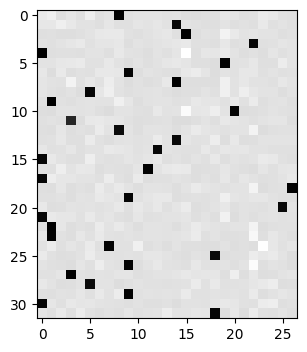

In [49]:
plt.figure(figsize=(4, 4))
plt.imshow(dlogits.detach(), cmap="gray")

In [50]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = (
    bngain
    * (hprebn - hprebn.mean(0, keepdim=True))
    / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5)
    + bnbias
)
print("max diff:", (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [51]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

dhprebn = (
    bngain
    * bnvar_inv
    / n
    * (n * dhpreact - dhpreact.sum(0) - n / (n - 1) * bnraw * (dhpreact * bnraw).sum(0))
)

cmp(
    "hprebn", dhprebn, hprebn
)  # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 6.984919309616089e-10


In [52]:
dhprebn.shape, bngain.shape, bnvar_inv.shape, dbnraw.shape, dbnraw.sum(0).shape

(torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([64]))

In [53]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
# Layer 1
W1 = (
    torch.randn((n_embd * block_size, n_hidden), generator=g)
    * (5 / 3)
    / ((n_embd * block_size) ** 0.5)
)
b1 = torch.randn(n_hidden, generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size  # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():
    # kick off optimization
    for i in range(max_steps):
        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

        # forward pass
        emb = C[Xb]  # embed the characters into vectors
        embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
        # Linear layer
        hprebn = embcat @ W1 + b1  # hidden layer pre-activation
        # BatchNorm layer
        # -------------------------------------------------------------
        bnmean = hprebn.mean(0, keepdim=True)
        bnvar = hprebn.var(0, keepdim=True, unbiased=True)
        bnvar_inv = (bnvar + 1e-5) ** -0.5
        bnraw = (hprebn - bnmean) * bnvar_inv
        hpreact = bngain * bnraw + bnbias
        # -------------------------------------------------------------
        # Non-linearity
        h = torch.tanh(hpreact)  # hidden layer
        logits = h @ W2 + b2  # output layer
        loss = F.cross_entropy(logits, Yb)  # loss function

        # backward pass
        for p in parameters:
            p.grad = None
        # loss.backward() # use this for correctness comparisons, delete it later!

        # manual backprop! #swole_doge_meme
        # -----------------
        dlogits = F.softmax(logits, 1)
        dlogits[range(n), Yb] -= 1
        dlogits /= n
        # 2nd layer backprop
        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits
        db2 = dlogits.sum(0)
        # tanh
        dhpreact = (1.0 - h**2) * dh
        # batchnorm backprop
        dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
        dbnbias = dhpreact.sum(0, keepdim=True)
        dhprebn = (
            bngain
            * bnvar_inv
            / n
            * (
                n * dhpreact
                - dhpreact.sum(0)
                - n / (n - 1) * bnraw * (dhpreact * bnraw).sum(0)
            )
        )
        # 1st layer
        dembcat = dhprebn @ W1.T
        dW1 = embcat.T @ dhprebn
        db1 = dhprebn.sum(0)
        # embedding
        demb = dembcat.view(emb.shape)
        dC = torch.zeros_like(C)
        for k in range(Xb.shape[0]):
            for j in range(Xb.shape[1]):
                ix = Xb[k, j]
                dC[ix] += demb[k, j]
        grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
        # -----------------

        # update
        lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
        for p, grad in zip(parameters, grads):
            # p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
            p.data += -lr * grad  # new way of swole doge TODO: enable

        # track stats
        if i % 10000 == 0:  # print every once in a while
            print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
        lossi.append(loss.log10().item())

    #   if i >= 100: # TODO: delete early breaking when you're ready to train the full net
    #     break

12297
      0/ 200000: 3.7950
  10000/ 200000: 2.1770
  20000/ 200000: 2.4129
  30000/ 200000: 2.4603
  40000/ 200000: 1.9513
  50000/ 200000: 2.4739
  60000/ 200000: 2.4539
  70000/ 200000: 2.0597
  80000/ 200000: 2.3374
  90000/ 200000: 2.2565
 100000/ 200000: 1.9186
 110000/ 200000: 2.2521
 120000/ 200000: 2.0599
 130000/ 200000: 2.3905
 140000/ 200000: 2.3164
 150000/ 200000: 2.1389
 160000/ 200000: 1.8956
 170000/ 200000: 1.7942
 180000/ 200000: 1.9470
 190000/ 200000: 1.9876


In [54]:
# useful for checking your gradients
# for p,g in zip(parameters, grads):
#   cmp(str(tuple(p.shape)), g, p)

In [55]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [56]:
# evaluate train and val loss


@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    emb = C[x]  # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5) ** -0.5 + bnbias
    h = torch.tanh(hpreact)  # (N, n_hidden)
    logits = h @ W2 + b2  # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 2.069471836090088
val 2.110116481781006


In [57]:
# I achieved:
# train 2.0718822479248047
# val 2.1162495613098145

In [58]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        # ------------
        # forward pass:
        # Embedding
        emb = C[torch.tensor([context])]  # (1,block_size,d)
        embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
        hpreact = embcat @ W1 + b1
        hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5) ** -0.5 + bnbias
        h = torch.tanh(hpreact)  # (N, n_hidden)
        logits = h @ W2 + b2  # (N, vocab_size)
        # ------------
        # Sample
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print("".join(itos[i] for i in out))

mora.
mayanniee.
madhayla.
reisha.
endraeg.
adelynnelin.
shi.
jenleigh.
sana.
arleigh.
malaia.
noshubergahira.
stin.
joselle.
jose.
casube.
geder.
yarul.
eli.
kayshayan.
